In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
from utils import plot, rolling_sharpe, plot_rolling_sharpe, plot_rolling_vol
%matplotlib inline

In [2]:
cash = 80000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-07-08_15-40_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
micro_contracts = df[df.contract.str.startswith('M')]
macro_contracts = df[~df.contract.str.startswith('M')]
micro_contracts['amount'] /= 10
df = pd.concat([macro_contracts, micro_contracts]).sort_index()
df.contract = df.contract.str.strip('M')
df['contract'] = df['contract'].apply(lambda x: x[:2])
df.contract = df.contract.str.strip()

In [4]:
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
time,,,,,,,,,
2018-06-01 12:50:30,GC,SELL,2.0,1301.30,1,ENTRY,4.84,0.00,80000.00
2018-06-01 12:50:30,GC,SELL,0.9,1301.30,2,ENTRY,4.23,0.00,80000.00
2018-06-01 14:38:30,GC,BUY,2.0,1296.90,3,STOP-LOSS,4.84,870.32,80870.32
2018-06-01 14:38:30,GC,BUY,0.9,1296.90,4,STOP-LOSS,4.23,387.54,81257.86
2018-06-01 15:35:30,NQ,BUY,2.0,7029.50,5,ENTRY,4.20,0.00,81257.86
...,...,...,...,...,...,...,...,...,...
2019-12-30 10:48:30,GC,SELL,0.6,1515.30,6646,STOP-LOSS,2.82,-221.64,649172.88
2019-12-30 16:13:30,NQ,SELL,20.0,8707.25,6647,ENTRY,42.00,0.00,649172.88
2019-12-30 16:13:30,NQ,SELL,0.6,8707.25,6648,ENTRY,2.82,0.00,649172.88


In [5]:
pnl = df.groupby('contract').realizedPNL.sum()
pnl['total'] = pnl.sum()
pnl

contract
ES       138768.32
GC        69640.20
NQ       209790.30
YM       151502.42
total    569701.24
Name: realizedPNL, dtype: float64

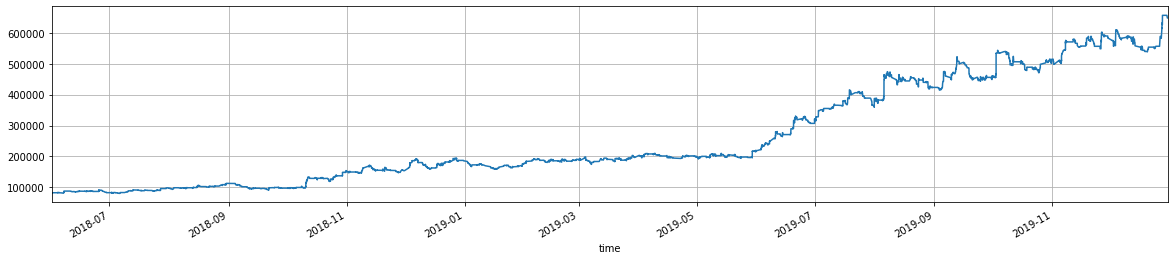

In [6]:
df.cash.plot(figsize=(20,4), grid=True);

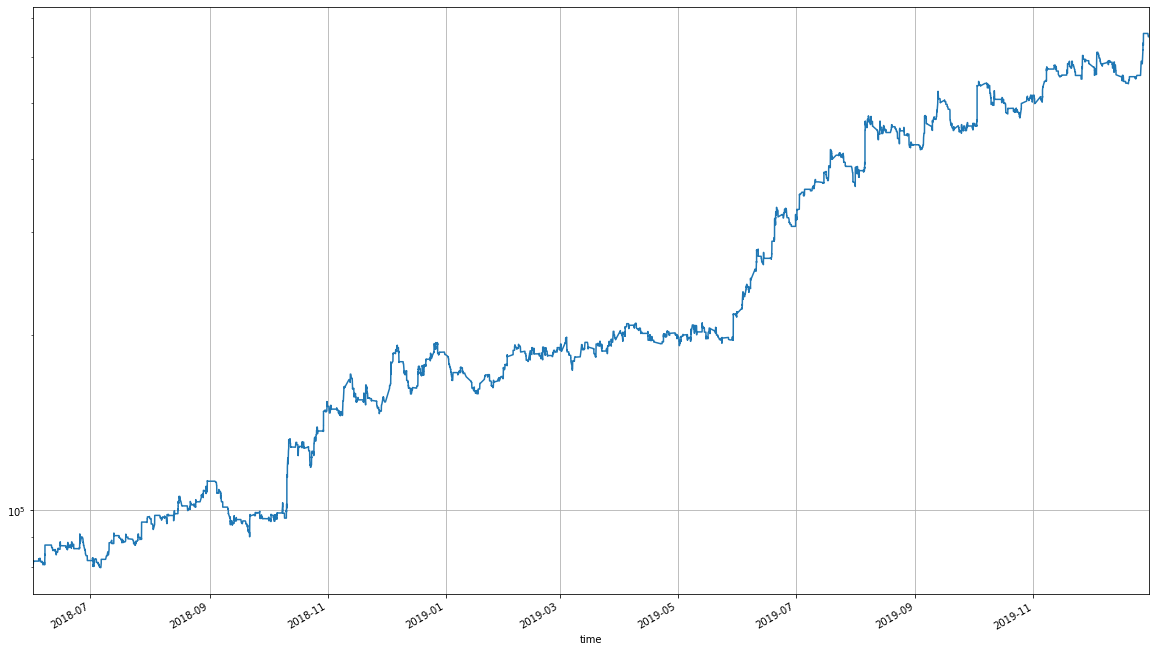

In [7]:
df.cash.plot(figsize=(20,12), grid=True, logy=True);

In [8]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, aggfunc='sum', columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [9]:
#monthly average number of transactions
daily_count = df.groupby('contract').action.resample('B').count()
zero_index = set(daily_count.index.get_level_values(0))
monthly_count = daily_count.groupby('contract').resample('M', level=1).mean()
average_monthly_contracts = pd.DataFrame({contract: monthly_count[contract] for contract in zero_index})
average_monthly_contracts

,GC,ES,NQ,YM
time,,,,
2018-06-30,3.523810,1.333333,8.666667,2.200000
2018-07-31,3.545455,1.090909,5.363636,1.454545
2018-08-31,4.391304,0.869565,6.173913,1.391304
2018-09-30,4.050000,1.300000,7.700000,1.300000
2018-10-31,4.086957,3.130435,13.304348,3.652174
2018-11-30,2.636364,1.818182,11.909091,2.363636
2018-12-31,3.047619,3.047619,12.857143,3.619048
2019-01-31,2.521739,1.652174,8.173913,2.434783
2019-02-28,2.900000,0.900000,5.900000,1.500000


In [10]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     652
 GC    1596
 NQ    3516
 YM     872
 Name: action, dtype: int64, 6636)

In [11]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.582524
 GC    3.873786
 NQ    8.533981
 YM    2.116505
 Name: action, dtype: float64, 16.106796116504853)

In [12]:
# commission paid
comm = df.groupby('contract').commission.sum()
comm['total'] = comm.sum()
comm

contract
ES        4569.18
GC       18347.80
NQ       25062.20
YM        6285.58
total    54264.76
Name: commission, dtype: float64

In [13]:
# commission paid as percent of pnl
round((comm/pnl) *100, 1)

contract
ES        3.3
GC       26.3
NQ       11.9
YM        4.1
total     9.5
dtype: float64

In [14]:
# per trade stats (pro rated per macro contract)
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss', 
                                'win_ratio', 'EV/contract', 'contracts_per_position', 'number_of_positions', 
                                'number_of_contracts'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    d['pnl_per_contract'] = d.realizedPNL / d.amount
    row['average_PNL'] = round(d['pnl_per_contract'].mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0])['pnl_per_contract'].mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0])['pnl_per_contract'].mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV/contract'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['contracts_per_position'] = round(d.amount.sum() / d.amount.count(), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    row['number_of_contracts'] = d.amount.sum()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV/contract,contracts_per_position,number_of_positions,number_of_contracts
GC,0.38,17.80,477.49,-262.09,1.82,18.95,4.54,798.0,3622.6
NQ,0.40,34.02,460.74,-255.08,1.81,31.25,3.12,1758.0,5493.0
YM,0.44,120.73,757.62,-375.78,2.02,122.92,3.13,436.0,1365.7
ES,0.45,137.52,988.07,-569.69,1.73,131.30,3.04,326.0,991.7
total,0.41,51.68,564.23,-300.35,1.88,54.13,3.46,3318.0,11473.0


In [15]:
edge = results['win_ratio'] - ((1-results['success_rate'])/ results['success_rate'])
edge

GC       0.188421
NQ       0.310000
YM       0.747273
ES       0.507778
total    0.440976
dtype: float64

In [16]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
daily_scaled

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.00,5031.44,2067.28,0.00,1774.68
2018-06-04,0.00,0.00,1061.76,0.00,265.44
2018-06-05,0.00,-4138.08,2824.64,-129.12,-360.64
2018-06-06,0.00,-2624.56,-1669.12,0.00,-1073.42
2018-06-07,12498.88,-3436.56,3302.88,13730.88,6524.02
...,...,...,...,...,...
2019-12-24,0.00,31282.08,0.00,0.00,7820.52
2019-12-25,0.00,0.00,0.00,0.00,0.00
2019-12-26,0.00,127445.04,0.00,0.00,31861.26


In [17]:
returns = daily.divide(total_cumsum, axis=0)
returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-01,0.000000,0.015723,0.006460,0.000000,0.022184
2018-06-04,0.000000,0.000000,0.003246,0.000000,0.003246
2018-06-05,0.000000,-0.012610,0.008607,-0.000393,-0.004396
2018-06-06,0.000000,-0.008033,-0.005109,0.000000,-0.013142
2018-06-07,0.038765,-0.010659,0.010244,0.042586,0.080937
...,...,...,...,...,...
2019-12-24,0.000000,0.014232,0.000000,0.000000,0.014232
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.057167,0.000000,0.000000,0.057167


In [18]:
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)

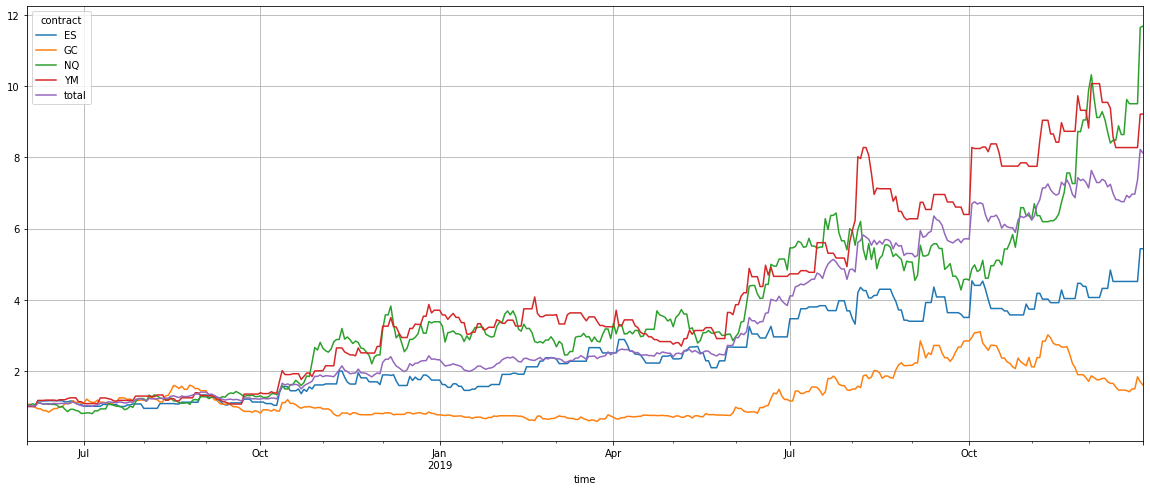

In [19]:
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [20]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,-0.063005,0.206999,0.478562,0.650749
GC,-0.063005,1.000000,0.036909,0.010859,0.442909
NQ,0.206999,0.036909,1.000000,0.228572,0.628072
YM,0.478562,0.010859,0.228572,1.000000,0.681358
total,0.650749,0.442909,0.628072,0.681358,1.000000


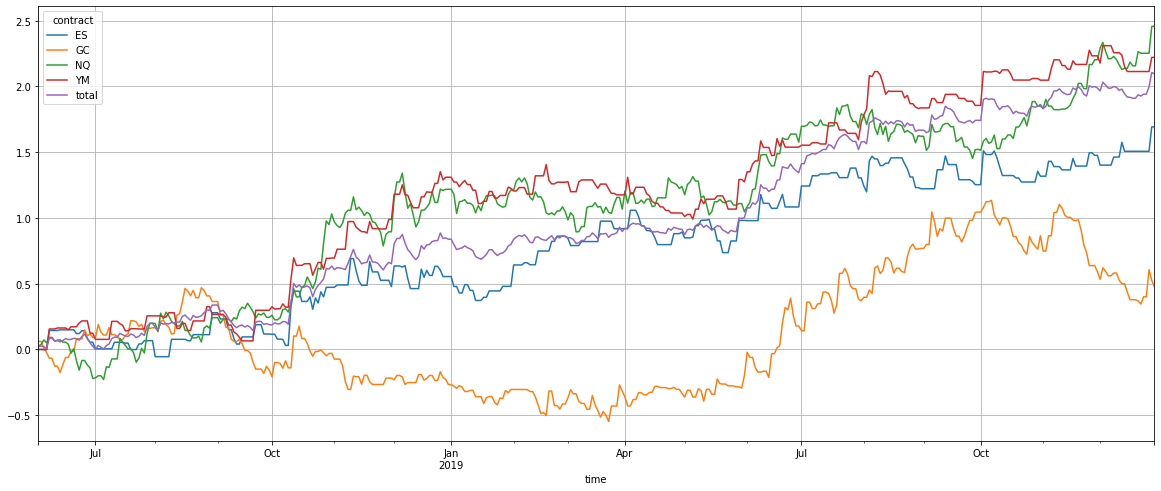

In [21]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

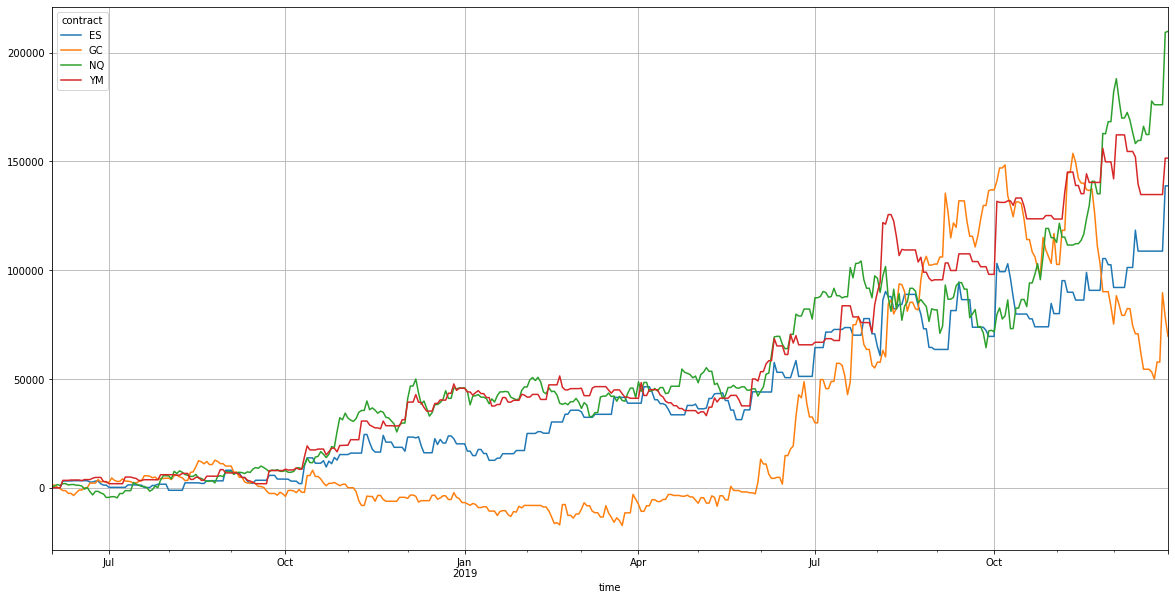

In [22]:
# dollar returns cummulative
by_contract.resample('B').sum().drop('total', axis=1).cumsum().plot(figsize=(20,10), grid=True);

In [23]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,GC,NQ,YM,total
Annual return,1.815126,0.334849,3.498885,2.889887,2.600574
Cumulative returns,4.431168,0.603509,10.688926,8.215102,7.121266
Annual volatility,0.860962,0.944606,0.928177,0.822179,0.535546
Sharpe ratio,1.601703,0.750362,2.071745,2.035570,2.653533
Calmar ratio,6.590685,0.524740,9.715907,8.518186,14.386757
Stability,0.940983,0.309629,0.899343,0.927348,0.960067
Max drawdown,-0.275408,-0.638124,-0.360119,-0.339261,-0.180762
Omega ratio,1.549700,1.161945,1.466618,1.723398,1.674771
Sortino ratio,3.500012,1.416015,3.757258,4.726991,5.915453
Skew,2.347568,1.637569,0.905502,2.422782,1.943164


In [24]:
#non-scaled returns
stats_non_scaled = pd.DataFrame()
for col in daily.columns:
    stats_non_scaled[col] = perf_stats(returns[col])
stats_non_scaled

,ES,GC,NQ,YM,total
Annual return,0.379794,0.161588,0.574196,0.488052,2.600574
Cumulative returns,0.692721,0.277483,1.099788,0.915212,7.121266
Annual volatility,0.215240,0.236151,0.232044,0.205545,0.535546
Sharpe ratio,1.601703,0.750362,2.071745,2.035570,2.653533
Calmar ratio,5.216563,0.809772,6.167463,5.313488,14.386757
Stability,0.958673,0.493508,0.929193,0.940573,0.960067
Max drawdown,-0.072805,-0.199547,-0.093101,-0.091852,-0.180762
Omega ratio,1.549700,1.161945,1.466618,1.723398,1.674771
Sortino ratio,3.500012,1.416015,3.757258,4.726991,5.915453
Skew,2.347568,1.637569,0.905502,2.422782,1.943164


In [25]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,1.64,2.68,-5.01,3.49,2.45
2018-07-31,0.39,2.24,11.94,3.68,19.02
2018-08-31,6.08,5.75,1.62,0.67,14.94
2018-09-30,-3.67,-11.86,0.23,1.39,-13.79
2018-10-31,10.81,4.31,23.23,11.51,55.98
2018-11-30,1.12,-4.22,-2.79,8.31,1.74
2018-12-31,2.68,-1.03,10.21,9.16,20.60
2019-01-31,-1.62,-0.74,0.44,-1.81,-3.83
2019-02-28,10.48,-2.19,-3.70,1.59,5.94


In [26]:
monthly_returns.total.mean(), monthly_returns.total.median()

(12.615263157894736, 9.39)

In [27]:
monthly_returns.sort_values('total', ascending = False).total

time
2018-10-31    55.98
2019-06-30    40.81
2019-07-31    26.20
2018-12-31    20.60
2018-07-31    19.02
2018-08-31    14.94
2019-11-30    13.32
2019-10-31    12.75
2019-12-31    11.27
2019-08-31     9.39
2019-05-31     9.24
2019-09-30     7.86
2019-02-28     5.94
2019-03-31     4.06
2018-06-30     2.45
2019-04-30     1.74
2018-11-30     1.74
2019-01-31    -3.83
2018-09-30   -13.79
Name: total, dtype: float64

In [28]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        69.0
GC        28.0
NQ       110.0
YM        92.0
total    712.0
dtype: float64

In [29]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:45:30,YM,BUY,26063.00,33558.80
2019-10-02 21:00:00,ES,BUY,2893.75,33208.00
2019-12-27 15:12:00,NQ,SELL,8829.25,33044.40
2019-12-26 17:19:00,GC,SELL,1513.70,31703.20
2019-12-27 21:50:30,ES,SELL,3235.50,30007.90
...,...,...,...,...
2019-11-26 15:59:30,GC,BUY,1462.20,-8451.96
2019-12-12 14:03:00,YM,SELL,27873.00,-8547.20
2019-12-13 16:30:30,YM,SELL,28180.00,-8808.80


In [30]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,33539.56,4160.00,7986.34,33558.80,79244.70
2019-12-27,30007.90,-11385.58,33227.46,16737.00,68586.78
2019-08-05,25559.65,5498.10,7626.76,27437.76,66122.27
2019-09-05,0.00,29355.06,18925.20,7731.64,56011.90
2019-11-26,14623.11,-12948.58,27703.68,15692.80,45071.01
...,...,...,...,...,...
2019-12-13,-9628.32,0.00,1413.68,-12526.20,-20740.84
2019-11-22,0.00,-15108.00,-5703.26,0.00,-20811.26
2019-08-28,-8565.35,-4051.92,-6883.94,-2713.60,-22214.81


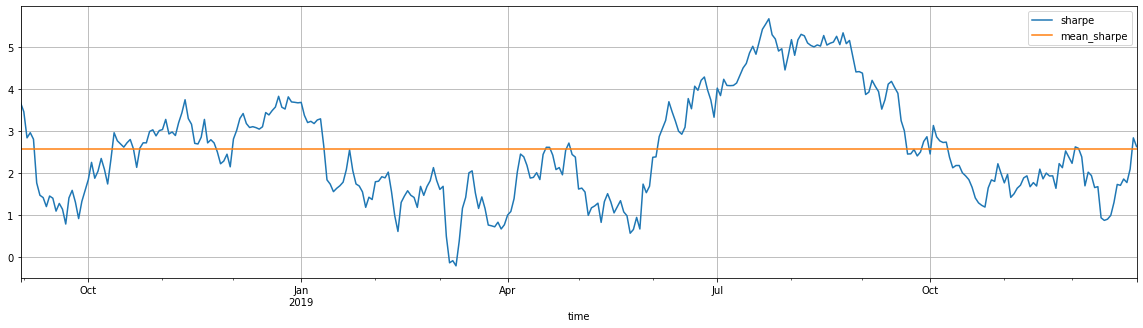

In [31]:
plot_rolling_sharpe(returns.total, 3)

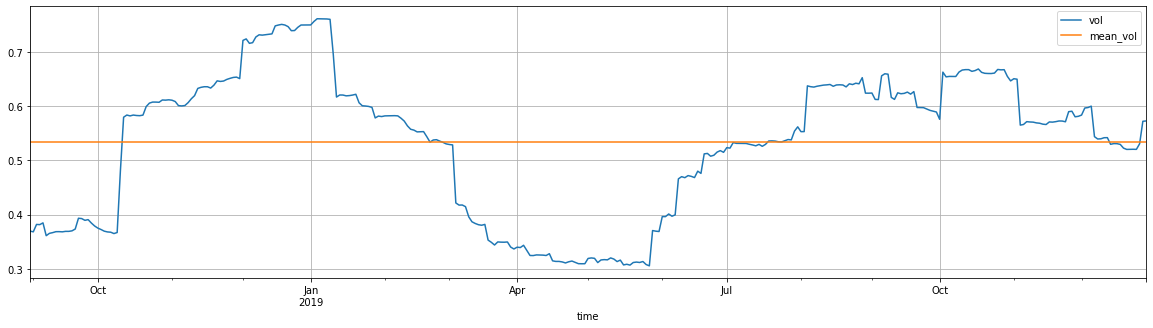

In [32]:
plot_rolling_vol(returns.total, 3)